# **Install PyTorch**





In [ ]:
!pip install -U torch torchvision tqdm lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 135.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## **ID Class Imbalance (Shadow vs. Object)**

In [ ]:
# ============================================
# STEP 1: Mount Google Drive
# ============================================
# Enables access to sonar dataset stored in Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ============================================
# STEP 2: Import libraries and set paths
# ============================================
import os
from pathlib import Path
from xml.etree import ElementTree as ET

# Define the annotation directory (Pascal VOC format)
ANNOTATION_DIR = Path("/content/drive/MyDrive/sonar-object-detection/data/line2voc/Annotations")

# Set up counters for both object classes
object_count = 0
shadow_count = 0

# ============================================
# STEP 3: Iterate through annotations and count labels
# ============================================
# Parse each XML annotation file and count number of "object" and "shadow" instances

for xml_file in ANNOTATION_DIR.glob("*.xml"):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Each file may contain multiple objects -> loop through all of them
    for obj in root.findall("object"):
        label = obj.find("name").text.strip().lower()  # Normalize label format

        if label == "object":
            object_count += 1
        elif label == "shadow":
            shadow_count += 1
        else:
            continue  # Skip unexpected or unlabelled classes (defensive coding)

# ============================================
# STEP 4: Print a quick summary
# ============================================
total = object_count + shadow_count

print("=== Annotation Summary ===")
print(f"Number of 'object' annotations : {object_count}")
print(f"Number of 'shadow' annotations : {shadow_count}")
print(f"Total annotations              : {total}")
print(f"Percentage 'object'            : {100 * object_count / total:.2f}%")
print(f"Percentage 'shadow'            : {100 * shadow_count / total:.2f}%")

Mounted at /content/drive
=== Annotation Summary ===
Number of 'object' annotations : 12842
Number of 'shadow' annotations : 15079
Total annotations              : 27921
Percentage 'object'            : 45.99%
Percentage 'shadow'            : 54.01%


# **Rebuild and Validate VOC Dataset Splits**

In [ ]:
# =============================================================
# SPLIT FILE INTEGRITY VERIFICATION AND REBUILD — VOC FORMAT
# Purpose: Rebuild train/val/test split files with valid image references
# =============================================================

from google.colab import drive
from pathlib import Path
import shutil
import random

# -------------------------------------------------------------
# STEP 0: Mount Google Drive and set paths
# -------------------------------------------------------------
drive.mount('/content/drive')

# Define dataset and folder structure
DATASET_DIR = Path("/content/drive/MyDrive/sonar-object-detection/data/line2voc")
image_dir = DATASET_DIR / "JPEGImages"
split_dir = DATASET_DIR / "ImageSets" / "Main"

# -------------------------------------------------------------
# STEP 1: Backup original split files
# -------------------------------------------------------------
# Save a copy of train.txt, val.txt, and test.txt for safekeeping

for split in ["train", "val", "test"]:
    src = split_dir / f"{split}.txt"
    dst = split_dir / f"{split}_original.txt"
    if src.exists():
        shutil.copy(src, dst)
print("Original split files backed up.")

# -------------------------------------------------------------
# STEP 2: Read existing test set (do not modify)
# -------------------------------------------------------------
# The test set is held out and excluded from reshuffling

test_path = split_dir / "test.txt"
if test_path.exists():
    test_ids = test_path.read_text().splitlines()
    test_set = set(test_ids)
else:
    test_set = set()
    print("test.txt not found, assuming empty test set.")

# -------------------------------------------------------------
# STEP 3: Collect all valid image filenames (no extensions)
# -------------------------------------------------------------
all_valid_ids = {f.stem for f in image_dir.glob("*.jpg")}

# Remove test set from train/val candidates
trainval_pool = list(all_valid_ids - test_set)
trainval_pool.sort()         # Keep deterministic order for debugging
random.seed(42)              # Fix seed for reproducibility
random.shuffle(trainval_pool)

# -------------------------------------------------------------
# STEP 4: Split train/val (85% / 15%)
# -------------------------------------------------------------
split_idx = int(0.85 * len(trainval_pool))
train_ids = trainval_pool[:split_idx]
val_ids = trainval_pool[split_idx:]

# -------------------------------------------------------------
# STEP 5: Write updated split files to disk
# -------------------------------------------------------------
(split_dir / "train.txt").write_text("\n".join(train_ids) + "\n")
(split_dir / "val.txt").write_text("\n".join(val_ids) + "\n")

# test.txt is left unchanged (still linked to original content)
if test_path.exists():
    test_ids = test_path.read_text().splitlines()
else:
    test_ids = []

# -------------------------------------------------------------
# STEP 6: Print summary stats
# -------------------------------------------------------------
print(f"train.txt: {len(train_ids)} entries")
print(f"val.txt  : {len(val_ids)} entries")
print(f"test.txt : {len(test_ids)} entries (unchanged)")

# Print split ratio summary (optional but helpful)
total = len(train_ids) + len(val_ids) + len(test_ids)
print(f"\nRatio summary:")
print(f"  Train: {len(train_ids)} ({len(train_ids)/total:.2%})")
print(f"  Val  : {len(val_ids)} ({len(val_ids)/total:.2%})")
print(f"  Test : {len(test_ids)} ({len(test_ids)/total:.2%})")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original split files backed up.
train.txt: 1366 entries
val.txt  : 242 entries
test.txt : 180 entries (unchanged)

Ratio summary:
  Train: 1366 (76.40%)
  Val  : 242 (13.53%)
  Test : 180 (10.07%)


## **Setup: Load Raw Dataset, Define VOCDataset, Build, and Train Faster R-CNN Model**

In [ ]:
# =============================================================
# TRAIN FASTER R-CNN (20 EPOCHS) ON RAW SONAR DATA (Pascal VOC)
# =============================================================
# Trains a COCO-pretrained Faster R-CNN model on raw sonar images
# using Pascal VOC-style annotations. Model is saved after 20 epochs.

# -------------------------------------------------------------
# STEP 0: Mount Google Drive and Import Required Libraries
# -------------------------------------------------------------

from google.colab import drive
drive.mount('/content/drive')

import os
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm

# -------------------------------------------------------------
# STEP 1: Dataset Paths and Split Check
# -------------------------------------------------------------
# Ensure all images listed in train.txt and val.txt exist on disk

DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc"
split_dir = Path(DATASET_DIR) / "ImageSets" / "Main"
image_dir = Path(DATASET_DIR) / "JPEGImages"

def check_split(txt_file, image_dir):
    with open(txt_file) as f:
        ids = [x.strip() for x in f.readlines()]
    return [i for i in ids if not (image_dir / f"{i}.jpg").exists()]

missing_train = check_split(split_dir / "train.txt", image_dir)
missing_val = check_split(split_dir / "val.txt", image_dir)

assert not missing_train, f"Missing train images: {missing_train}"
assert not missing_val, f"Missing val images: {missing_val}"
print("All training and validation images are accounted for.")

# -------------------------------------------------------------
# STEP 2: Define Custom VOCDataset Loader
# -------------------------------------------------------------
# Parses VOC XML and returns a torch-compatible detection dictionary

class VOCDataset(Dataset):
    def __init__(self, root, image_set="train", transforms=None):
        self.root = root
        self.transforms = transforms
        self.image_dir = os.path.join(root, "JPEGImages")
        self.ann_dir = os.path.join(root, "Annotations")
        split_path = os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")
        with open(split_path) as f:
            self.image_ids = [x.strip() for x in f.readlines()]
        self.class_map = {"object": 1, "shadow": 2}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        ann_path = os.path.join(self.ann_dir, f"{img_id}.xml")

        img = Image.open(img_path).convert("RGB")
        target = self.parse_voc_xml(ann_path)

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes, labels = [], []

        for obj in root.findall("object"):
            label = self.class_map.get(obj.find("name").text.strip())
            if label is None:
                continue

            bbox = obj.find("bndbox")
            xmin = int(float(bbox.find("xmin").text))
            ymin = int(float(bbox.find("ymin").text))
            xmax = int(float(bbox.find("xmax").text))
            ymax = int(float(bbox.find("ymax").text))

            if xmax - xmin < 1 or ymax - ymin < 1:
                continue  # Skip degenerate boxes

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        if not boxes:
            # Avoid crashing on empty annotations (very rare)
            boxes = [[0, 0, 1, 1]]
            labels = [0]

        return {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

# -------------------------------------------------------------
# STEP 3: Prepare Datasets and DataLoaders
# -------------------------------------------------------------
transform = T.ToTensor()

train_dataset = VOCDataset(DATASET_DIR, image_set="train", transforms=transform)
val_dataset   = VOCDataset(DATASET_DIR, image_set="val", transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# -------------------------------------------------------------
# STEP 4: Build Faster R-CNN Model (COCO Pretrained)
# -------------------------------------------------------------
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)  # 0 = background
model.to(device)

# -------------------------------------------------------------
# STEP 5: Train the Model for 20 Epochs
# -------------------------------------------------------------
# Optimizer: AdamW for generalization on small datasets
# LR scheduler: reduce learning rate after 10 epochs

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(20):
    model.train()
    total_loss = 0.0

    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} — Avg Loss: {avg_loss:.4f}")

# -------------------------------------------------------------
# STEP 6: Save Trained Model Checkpoint
# -------------------------------------------------------------
save_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All training and validation images are accounted for.
Using device: cuda
Training samples: 1366
Validation samples: 242
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 231MB/s]
Epoch 1/20: 100%|██████████| 171/171 [01:38<00:00,  1.74it/s]


Epoch 1 — Avg Loss: 1.2649


Epoch 2/20: 100%|██████████| 171/171 [00:47<00:00,  3.59it/s]


Epoch 2 — Avg Loss: 1.1192


Epoch 3/20: 100%|██████████| 171/171 [00:47<00:00,  3.57it/s]


Epoch 3 — Avg Loss: 1.0810


Epoch 4/20: 100%|██████████| 171/171 [00:47<00:00,  3.58it/s]


Epoch 4 — Avg Loss: 1.0581


Epoch 5/20: 100%|██████████| 171/171 [00:47<00:00,  3.58it/s]


Epoch 5 — Avg Loss: 1.0554


Epoch 6/20: 100%|██████████| 171/171 [00:47<00:00,  3.58it/s]


Epoch 6 — Avg Loss: 1.0325


Epoch 7/20: 100%|██████████| 171/171 [00:47<00:00,  3.59it/s]


Epoch 7 — Avg Loss: 1.0190


Epoch 8/20: 100%|██████████| 171/171 [00:47<00:00,  3.57it/s]


Epoch 8 — Avg Loss: 1.0097


Epoch 9/20: 100%|██████████| 171/171 [00:47<00:00,  3.57it/s]


Epoch 9 — Avg Loss: 1.0013


Epoch 10/20: 100%|██████████| 171/171 [00:47<00:00,  3.58it/s]


Epoch 10 — Avg Loss: 0.9799


Epoch 11/20: 100%|██████████| 171/171 [00:47<00:00,  3.58it/s]


Epoch 11 — Avg Loss: 0.9294


Epoch 12/20: 100%|██████████| 171/171 [00:47<00:00,  3.59it/s]


Epoch 12 — Avg Loss: 0.9043


Epoch 13/20: 100%|██████████| 171/171 [00:47<00:00,  3.58it/s]


Epoch 13 — Avg Loss: 0.8907


Epoch 14/20: 100%|██████████| 171/171 [00:47<00:00,  3.58it/s]


Epoch 14 — Avg Loss: 0.8753


Epoch 15/20: 100%|██████████| 171/171 [00:47<00:00,  3.58it/s]


Epoch 15 — Avg Loss: 0.8654


Epoch 16/20: 100%|██████████| 171/171 [00:47<00:00,  3.57it/s]


Epoch 16 — Avg Loss: 0.8533


Epoch 17/20: 100%|██████████| 171/171 [00:48<00:00,  3.56it/s]


Epoch 17 — Avg Loss: 0.8421


Epoch 18/20: 100%|██████████| 171/171 [00:48<00:00,  3.56it/s]


Epoch 18 — Avg Loss: 0.8247


Epoch 19/20: 100%|██████████| 171/171 [00:47<00:00,  3.58it/s]


Epoch 19 — Avg Loss: 0.8131


Epoch 20/20: 100%|██████████| 171/171 [00:48<00:00,  3.56it/s]


Epoch 20 — Avg Loss: 0.7991
Model saved to: /content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth


# **Full Inference: Baseline 20 Epoch**

In [ ]:
# =============================================================
# BATCH INFERENCE: FASTER R-CNN BASELINE (20 EPOCHS, RAW DATA)
# =============================================================
# This script runs inference using the trained 20-epoch Faster R-CNN model
# on the raw sonar dataset and saves annotated images + CSV predictions.

import os
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# -------------------------------------------------------------
# STEP 1: PATHS AND DEVICE
# -------------------------------------------------------------
# Define input paths, model location, and output folders

PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR      = PROJECT_ROOT / "data" / "line2voc" / "JPEGImages"
MODEL_PATH   = PROJECT_ROOT / "checkpoints" / "baseline_frcnn_20epoch.pth"
OUTPUT_DIR   = PROJECT_ROOT / "outputs" / "baseline_20epoch_vis"
PRED_CSV     = PROJECT_ROOT / "outputs" / "preds_baseline_20epoch.csv"

# Ensure output folders exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------------------------
# STEP 2: IMAGE DATASET
# -------------------------------------------------------------
# Custom Dataset for inference — returns both tensor (for model)
# and NumPy array (for OpenCV annotation)

class InferenceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted(list(Path(image_dir).glob("*.jpg")))
        self.transform = transform or ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_pil = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(img_pil)
        img_np = np.array(img_pil).astype(np.uint8)
        return img_tensor, img_path.name, img_np

# -------------------------------------------------------------
# STEP 3: LOAD TRAINED MODEL
# -------------------------------------------------------------
# Load Faster R-CNN with 3-class classifier (background, object, shadow)

model = fasterrcnn_resnet50_fpn(weights=None)  # No COCO weights needed here — we load our own
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load trained weights from the 20-epoch raw sonar model
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# -------------------------------------------------------------
# STEP 4: INFERENCE LOOP
# -------------------------------------------------------------
# Run inference over the full dataset and store all valid detections

CLASS_NAMES = {1: "object", 2: "shadow"}
CLASS_COLORS = {1: (0, 255, 0), 2: (0, 0, 255)}  # Green = object, Red = shadow

dataset = InferenceDataset(IMG_DIR)
loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=lambda x: list(zip(*x)))
all_preds = []

print("Running inference on raw sonar data using 20-epoch Faster R-CNN...")

for batch_imgs, batch_filenames, batch_np_imgs in tqdm(loader, desc="Running Inference"):
    imgs_tensor = [img.to(device) for img in batch_imgs]

    with torch.no_grad():  # No gradient calculation during inference
        outputs = model(imgs_tensor)

    for output, fname, img_np in zip(outputs, batch_filenames, batch_np_imgs):
        img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        boxes  = output["boxes"].cpu()
        scores = output["scores"].cpu()
        labels = output["labels"].cpu()

        for box, score, label in zip(boxes, scores, labels):
            score = score.item()
            if score < 0.5:
                continue  # Filter low-confidence predictions

            x1, y1, x2, y2 = map(int, box.tolist())
            class_id = label.item()
            class_name = CLASS_NAMES.get(class_id, "unknown")
            color = CLASS_COLORS.get(class_id, (255, 255, 255))  # Default to white for unknown classes

            # Save prediction to CSV-compatible dictionary
            all_preds.append({
                "filename": fname,
                "class_id": class_id,
                "class_name": class_name,
                "score": round(score, 4),
                "xmin": x1,
                "ymin": y1,
                "xmax": x2,
                "ymax": y2,
            })

            # Draw bounding box and label on image
            cv2.rectangle(img_cv2, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_cv2, f"{class_name} ({score:.2f})", (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        # Save annotated image
        out_path = OUTPUT_DIR / fname
        cv2.imwrite(str(out_path), img_cv2)

# -------------------------------------------------------------
# STEP 5: SAVE RESULTS
# -------------------------------------------------------------
# Export all predictions to CSV for evaluation and visual audit

df = pd.DataFrame(all_preds)
df.to_csv(PRED_CSV, index=False)

print("Inference complete.")
print(f"Total images processed: {len(dataset)}")
print(f"Visuals saved to      : {OUTPUT_DIR}")
print(f"Predictions saved to  : {PRED_CSV}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 235MB/s]


Running inference on raw sonar data using 20-epoch Faster R-CNN...


Running Inference: 100%|██████████| 447/447 [01:00<00:00,  7.34it/s]


Inference complete.
Total images processed: 1788
Visuals saved to      : /content/drive/MyDrive/sonar-object-detection/outputs/baseline_20epoch_vis
Predictions saved to  : /content/drive/MyDrive/sonar-object-detection/outputs/preds_baseline_20epoch.csv


## **evaluate_model.py**

In [ ]:
!pip install torchmetrics

In [ ]:
# =============================================================
# EVALUATE FASTER R-CNN BASELINE (20 EPOCHS) ON RAW SONAR DATA
# =============================================================
# This script loads the 20-epoch baseline Faster R-CNN model trained on
# raw sonar images and evaluates its detection performance on the validation set
# using TorchMetrics (mAP@0.5, mAR@100, and per-class metrics).

import sys
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# -------------------------------------------------------------
# STEP 1: Load Custom VOCDataset Loader
# -------------------------------------------------------------
# Custom dataset wrapper with Pascal VOC format parsing
# Class map (in voc_dataset.py): { "object": 1, "shadow": 2 }

sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

# -------------------------------------------------------------
# STEP 2: Initialize Model and Load Trained Weights
# -------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Faster R-CNN with custom classification head for 3 classes
model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load the 20-epoch trained model checkpoint (raw sonar data)
model_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# -------------------------------------------------------------
# STEP 3: Define Evaluation Function Using TorchMetrics
# -------------------------------------------------------------
def evaluate(model, dataset_root, image_set="val", batch_size=8):
    """
    Runs inference on the specified dataset split using the provided Faster R-CNN model,
    and computes object detection metrics using TorchMetrics.
    """

    # Load Pascal VOC-style dataset split
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    # Initialize TorchMetrics wrapper for mAP/mAR calculation
    metric = MeanAveragePrecision()
    label_map = {1: "object", 2: "shadow"}  # Maps class IDs to label names

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(imgs)

            preds, gts = [], []
            for o, t in zip(outputs, targets):
                # Skip samples with no detections (helps avoid metric errors)
                if o["boxes"].nelement() == 0:
                    continue

                preds.append({
                    "boxes": o["boxes"].cpu(),
                    "scores": o["scores"].cpu(),
                    "labels": o["labels"].cpu()
                })
                gts.append({
                    "boxes": t["boxes"].cpu(),
                    "labels": t["labels"].cpu()
                })

            if preds and gts:
                metric.update(preds, gts)

    # -------------------------------------------------------------
    # STEP 4: Print Results
    # -------------------------------------------------------------

    results = metric.compute()

    print("\nEvaluation Results — Faster R-CNN Baseline (Raw Dataset, 20 Epochs):")
    for k, v in results.items():
        if isinstance(v, torch.Tensor) and v.numel() == 1:
            print(f"{k}: {v.item():.4f}")
        else:
            print(f"{k}: {v}")

    # Print per-class mAP@0.5
    print("\nPer-class mAP@0.50:")
    per_class_ap = results.get("map_50_per_class")
    if isinstance(per_class_ap, torch.Tensor) and per_class_ap.ndim > 0:
        for idx, score in enumerate(per_class_ap):
            class_id = idx + 1  # skip background (index 0)
            print(f"  {label_map.get(class_id, f'class_{class_id}')}: {score:.4f}")
    else:
        print("  Not available — no valid detections for one or more classes.")

    # Print per-class recall (mAR@100)
    print("\nPer-class Recall (mar_100_per_class):")
    per_class_recall = results.get("mar_100_per_class")
    if isinstance(per_class_recall, torch.Tensor) and per_class_recall.ndim > 0:
        for idx, score in enumerate(per_class_recall):
            class_id = idx + 1
            print(f"  {label_map.get(class_id, f'class_{class_id}')}: {score:.4f}")
    else:
        print("  Not available — no valid detections for one or more classes.")

# -------------------------------------------------------------
# STEP 4: Execute Evaluation on Raw Validation Set
# -------------------------------------------------------------
evaluate(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc",
    image_set="val",
    batch_size=4
)


Evaluation Results — Faster R-CNN Baseline (Raw Dataset, 20 Epochs):
map: 0.0423
map_50: 0.1621
map_75: 0.0076
map_small: 0.0286
map_medium: 0.0600
map_large: 0.0335
mar_1: 0.0207
mar_10: 0.0940
mar_100: 0.1387
mar_small: 0.0967
mar_medium: 0.2022
mar_large: 0.1300
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: tensor([1, 2], dtype=torch.int32)

Per-class mAP@0.50:
  Not available — no valid detections for one or more classes.

Per-class Recall (mar_100_per_class):
  Not available — no valid detections for one or more classes.


## **Visualizations**

Image 1: 30 predictions above 0.50


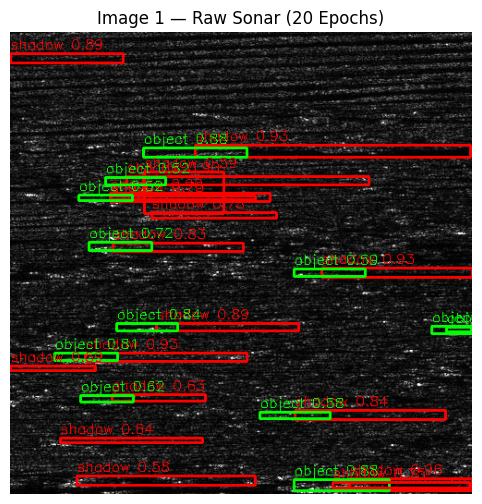

Image 2: 11 predictions above 0.50


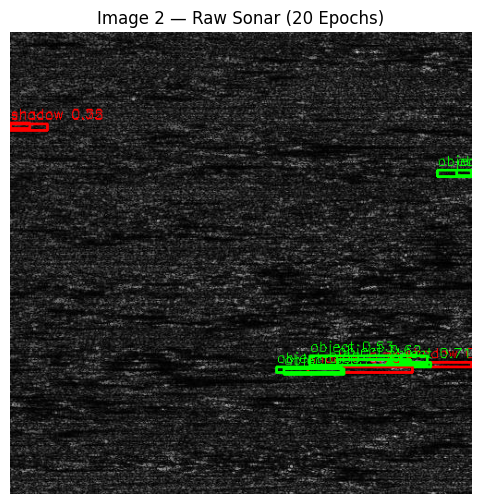

Image 3: 46 predictions above 0.50


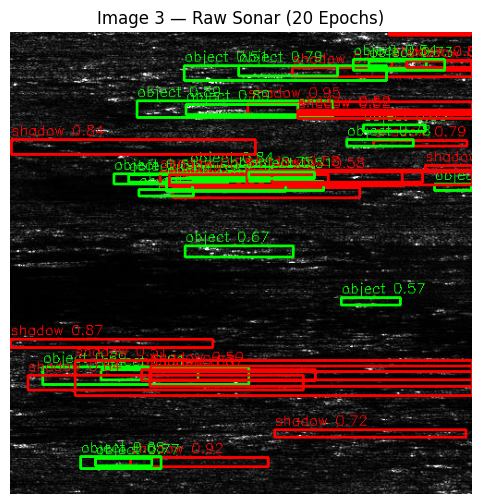

Image 4: 19 predictions above 0.50


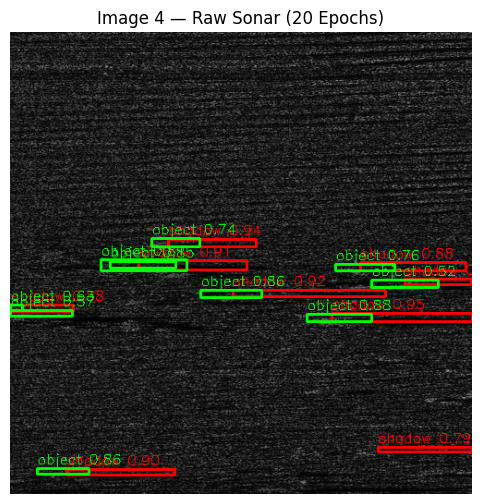

Image 5: 7 predictions above 0.50


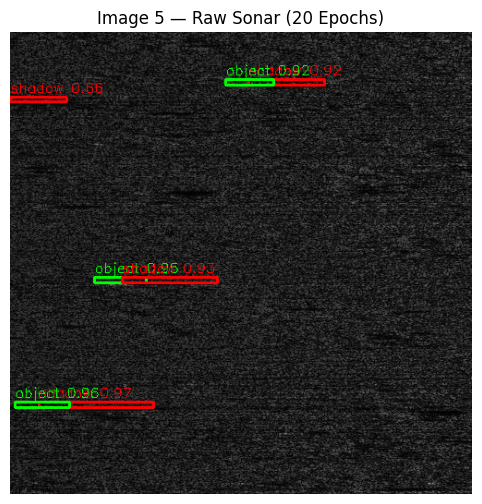

In [ ]:
# =============================================================
# VISUALIZE PREDICTIONS FROM FASTER R-CNN BASELINE (20 EPOCHS)
# =============================================================
# This script loads the trained Faster R-CNN model (20 epochs on raw data),
# and visualizes bounding box predictions on a few validation images.
# It overlays detections with class names and confidence scores.

import sys
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# -------------------------------------------------------------
# STEP 1: Load the Trained Model from Checkpoint
# -------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Faster R-CNN base with no pretrained head
model = fasterrcnn_resnet50_fpn(weights=None)

# Replace the default classification head for 3-class sonar task:
# background (0), object (1), shadow (2)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load weights from the 20-epoch baseline training
checkpoint_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# -------------------------------------------------------------
# STEP 2: Class Mapping for Annotations
# -------------------------------------------------------------

LABEL_NAMES = {
    1: "object",     # Green
    2: "shadow"      # Red
}

LABEL_COLORS = {
    1: (0, 255, 0),   # Green box for object
    2: (0, 0, 255)    # Red box for shadow
}

# -------------------------------------------------------------
# STEP 3: Load Custom Dataset Class (Pascal VOC format)
# -------------------------------------------------------------

sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

# -------------------------------------------------------------
# STEP 4: Define the Visualization Function
# -------------------------------------------------------------
def visualize(model, dataset_root, num_images=5, image_set="val", confidence_threshold=0.5):
    """
    Visualize bounding box predictions on a few validation images.
    """

    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())

    for i in range(min(num_images, len(dataset))):
        img, _ = dataset[i]
        img_tensor = img.unsqueeze(0).to(device)

        # Run inference
        with torch.no_grad():
            output = model(img_tensor)[0]

        # Convert image tensor back to NumPy format
        img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR).copy()

        count = 0
        for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
            if score < confidence_threshold:
                continue

            # Extract bounding box
            x1, y1, x2, y2 = box.int().tolist()
            class_id = label.item()
            class_name = LABEL_NAMES.get(class_id, "unknown")
            color = LABEL_COLORS.get(class_id, (255, 255, 255))  # fallback = white

            # Draw box and label
            cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)
            cv2.putText(
                img_np,
                f"{class_name} {score:.2f}",
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                1
            )

            count += 1

        print(f"Image {i+1}: {count} predictions above {confidence_threshold:.2f}")

        # Show the image with OpenCV overlays
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Raw Sonar Prediction — Image {i+1} (20 Epochs)")
        plt.show()

# -------------------------------------------------------------
# STEP 5: Run the Visualizer
# -------------------------------------------------------------
visualize(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc",
    num_images=5,
    image_set="val",
    confidence_threshold=0.5
)

## **Load Faster R-CNN and Start Training with Preprocessed Data**

### Train Faster RCNN Model (20 Epoch) on Denoised Data

In [ ]:
# =============================================================
# TRAIN FASTER R-CNN (20 EPOCHS) ON DENOISED SONAR DATASET (OPTIMIZED)
# =============================================================

# -------------------------------------------------------------
# STEP 0: Mount Google Drive and Import Libraries
# -------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

import os
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

import torchvision.transforms.v2 as T2
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Path to denoised sonar dataset (Pascal VOC format)
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed"

# -------------------------------------------------------------
# STEP 1: Check Train/Val Split Integrity
# -------------------------------------------------------------
def check_split(txt_file, image_dir):
    with open(txt_file) as f:
        ids = [x.strip() for x in f.readlines()]
    return [i for i in ids if not (image_dir / f"{i}.jpg").exists()]

split_dir = Path(DATASET_DIR) / "ImageSets" / "Main"
image_dir = Path(DATASET_DIR) / "JPEGImages"

assert not check_split(split_dir / "train.txt", image_dir), "Missing train images"
assert not check_split(split_dir / "val.txt", image_dir), "Missing val images"
print("All training and validation images are accounted for.")

# -------------------------------------------------------------
# STEP 2: Define VOCDataset Class
# -------------------------------------------------------------
class VOCDataset(Dataset):
    def __init__(self, root, image_set="train", transforms=None):
        self.root = root
        self.transforms = transforms
        self.image_dir = os.path.join(root, "JPEGImages")
        self.ann_dir = os.path.join(root, "Annotations")
        with open(os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")) as f:
            self.image_ids = [x.strip() for x in f.readlines()]
        self.class_map = {"object": 1, "shadow": 2}  # background = 0

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        ann_path = os.path.join(self.ann_dir, f"{img_id}.xml")

        img = Image.open(img_path).convert("RGB")
        target = self.parse_voc_xml(ann_path)

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes, labels = [], []

        for obj in root.findall("object"):
            label = self.class_map.get(obj.find("name").text.strip())
            if label is None:
                continue

            bbox = obj.find("bndbox")
            xmin = int(float(bbox.find("xmin").text))
            ymin = int(float(bbox.find("ymin").text))
            xmax = int(float(bbox.find("xmax").text))
            ymax = int(float(bbox.find("ymax").text))

            if xmax - xmin < 1 or ymax - ymin < 1:
                continue

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        if not boxes:
            boxes = [[0, 0, 1, 1]]
            labels = [0]

        return {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

# -------------------------------------------------------------
# STEP 3: Load Dataset and Create DataLoaders
# -------------------------------------------------------------
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

transform = T2.Compose([
    T2.ToImage(),
    T2.RandomHorizontalFlip(p=0.5),
    weights.transforms()
])

train_dataset = VOCDataset(DATASET_DIR, image_set="train", transforms=transform)
val_dataset = VOCDataset(DATASET_DIR, image_set="val", transforms=weights.transforms())

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# -------------------------------------------------------------
# STEP 4: Build Faster R-CNN Model (COCO Pretrained)
# -------------------------------------------------------------
model = fasterrcnn_resnet50_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)
model.to(device)

# -------------------------------------------------------------
# STEP 5: Configure Optimizer, Scheduler, and Gradient Clipping
# -------------------------------------------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# -------------------------------------------------------------
# STEP 6: Training Loop (20 Epochs)
# -------------------------------------------------------------
for epoch in range(20):
    model.train()
    total_loss = 0.0

    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} — Avg Loss: {avg_loss:.4f}")

# -------------------------------------------------------------
# STEP 7: Save Trained Model
# -------------------------------------------------------------
save_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_preprocessed_20epoch.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All training and validation images are accounted for.
Using device: cuda
Training samples: 1429
Validation samples: 179


Epoch 1/20: 100%|██████████| 179/179 [38:46<00:00, 13.00s/it]


Epoch 1 — Avg Loss: 1.2799


Epoch 2/20: 100%|██████████| 179/179 [00:50<00:00,  3.56it/s]


Epoch 2 — Avg Loss: 1.1671


Epoch 3/20: 100%|██████████| 179/179 [00:50<00:00,  3.56it/s]


Epoch 3 — Avg Loss: 1.1484


Epoch 4/20: 100%|██████████| 179/179 [00:50<00:00,  3.55it/s]


Epoch 4 — Avg Loss: 1.1313


Epoch 5/20: 100%|██████████| 179/179 [00:50<00:00,  3.54it/s]


Epoch 5 — Avg Loss: 1.1142


Epoch 6/20: 100%|██████████| 179/179 [00:50<00:00,  3.56it/s]


Epoch 6 — Avg Loss: 1.1103


Epoch 7/20: 100%|██████████| 179/179 [00:50<00:00,  3.54it/s]


Epoch 7 — Avg Loss: 1.0922


Epoch 8/20: 100%|██████████| 179/179 [00:50<00:00,  3.55it/s]


Epoch 8 — Avg Loss: 1.0896


Epoch 9/20: 100%|██████████| 179/179 [00:50<00:00,  3.53it/s]


Epoch 9 — Avg Loss: 1.0725


Epoch 10/20: 100%|██████████| 179/179 [00:50<00:00,  3.54it/s]


Epoch 10 — Avg Loss: 1.0520


Epoch 11/20: 100%|██████████| 179/179 [00:50<00:00,  3.52it/s]


Epoch 11 — Avg Loss: 1.0440


Epoch 12/20: 100%|██████████| 179/179 [00:50<00:00,  3.53it/s]


Epoch 12 — Avg Loss: 1.0207


Epoch 13/20: 100%|██████████| 179/179 [00:50<00:00,  3.53it/s]


Epoch 13 — Avg Loss: 1.0124


Epoch 14/20: 100%|██████████| 179/179 [00:50<00:00,  3.53it/s]


Epoch 14 — Avg Loss: 0.9968


Epoch 15/20: 100%|██████████| 179/179 [00:50<00:00,  3.54it/s]


Epoch 15 — Avg Loss: 0.9775


Epoch 16/20: 100%|██████████| 179/179 [00:50<00:00,  3.53it/s]


Epoch 16 — Avg Loss: 0.9584


Epoch 17/20: 100%|██████████| 179/179 [00:50<00:00,  3.54it/s]


Epoch 17 — Avg Loss: 0.9449


Epoch 18/20: 100%|██████████| 179/179 [00:50<00:00,  3.54it/s]


Epoch 18 — Avg Loss: 0.9290


Epoch 19/20: 100%|██████████| 179/179 [00:50<00:00,  3.53it/s]


Epoch 19 — Avg Loss: 0.9270


Epoch 20/20: 100%|██████████| 179/179 [00:50<00:00,  3.52it/s]


Epoch 20 — Avg Loss: 0.9205
Model saved to: /content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_preprocessed_20epoch.pth


### **Inference denoised batch**

In [ ]:
# ========================================================================
# BATCH INFERENCE: FASTER R-CNN (20 EPOCHS, DENOISED SONAR VALIDATION SET)
# ========================================================================

import os
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# ------------------------------------------------------------------------
# STEP 1: PATHS AND DEVICE SETUP
# ------------------------------------------------------------------------

PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR      = PROJECT_ROOT / "data" / "line2voc_preprocessed" / "JPEGImages"
MODEL_PATH   = PROJECT_ROOT / "checkpoints" / "baseline_frcnn_preprocessed_20epoch.pth"
OUTPUT_DIR   = PROJECT_ROOT / "outputs" / "vis_denoised_20epoch"
PRED_CSV     = PROJECT_ROOT / "outputs" / "preds_denoised_20epoch.csv"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------------------
# STEP 2: CUSTOM DATASET FOR BATCH INFERENCE
# ------------------------------------------------------------------------

class InferenceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted(list(Path(image_dir).glob("*.jpg")))
        self.transform = transform or ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_pil = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(img_pil)
        img_np = np.array(img_pil).astype(np.uint8)
        return img_tensor, img_path.name, img_np

# ------------------------------------------------------------------------
# STEP 3: LOAD MODEL AND CHECKPOINT
# ------------------------------------------------------------------------

model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# ------------------------------------------------------------------------
# STEP 4: BATCH INFERENCE AND VISUALIZATION
# ------------------------------------------------------------------------

CLASS_NAMES = {1: "object", 2: "shadow"}
CLASS_COLORS = {1: (0, 255, 0), 2: (0, 0, 255)}

dataset = InferenceDataset(IMG_DIR)
loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=lambda x: list(zip(*x)))

all_preds = []

print("Running inference on denoised sonar data using 20-epoch Faster R-CNN...")

for batch_imgs, batch_filenames, batch_np_imgs in tqdm(loader, desc="Running Inference"):
    imgs_tensor = [img.to(device) for img in batch_imgs]

    with torch.no_grad():
        outputs = model(imgs_tensor)

    for output, fname, img_np in zip(outputs, batch_filenames, batch_np_imgs):
        img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        boxes  = output["boxes"].cpu()
        scores = output["scores"].cpu()
        labels = output["labels"].cpu()

        for box, score, label in zip(boxes, scores, labels):
            score = score.item()
            if score < 0.5:
                continue

            x1, y1, x2, y2 = map(int, box.tolist())
            class_id = label.item()
            class_name = CLASS_NAMES.get(class_id, "unknown")
            color = CLASS_COLORS.get(class_id, (255, 255, 255))

            all_preds.append({
                "filename": fname,
                "class_id": class_id,
                "class_name": class_name,
                "score": round(score, 4),
                "xmin": x1,
                "ymin": y1,
                "xmax": x2,
                "ymax": y2,
            })

            cv2.rectangle(img_cv2, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_cv2, f"{class_name} ({score:.2f})", (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        out_path = OUTPUT_DIR / fname
        cv2.imwrite(str(out_path), img_cv2)

# ------------------------------------------------------------------------
# STEP 5: SAVE TO CSV
# ------------------------------------------------------------------------

df = pd.DataFrame(all_preds)
df.to_csv(PRED_CSV, index=False)

print("\nInference complete.")
print(f"Images processed: {len(dataset)}")
print(f"Visuals saved to: {OUTPUT_DIR}")
print(f"Predictions saved to: {PRED_CSV}")

Running inference on denoised sonar data using 20-epoch Faster R-CNN...


Running Inference: 100%|██████████| 447/447 [01:09<00:00,  6.39it/s]



Inference complete.
Images processed: 1788
Visuals saved to: /content/drive/MyDrive/sonar-object-detection/outputs/vis_denoised_20epoch
Predictions saved to: /content/drive/MyDrive/sonar-object-detection/outputs/preds_denoised_20epoch.csv


## **Evaluation of Model with Denoised Data**

In [ ]:
!pip install torchmetrics

In [ ]:
# =============================================================
# EVALUATE FASTER R-CNN MODEL (20 EPOCHS) ON DENOISED DATA
# =============================================================

# -------------------------------------------------------------
# STEP 1: Import Libraries and Custom Dataset
# -------------------------------------------------------------

import sys
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Add custom dataset loader to path
sys.path.append('/content/drive/MyDrive/sonar-object-detection/scripts')
from voc_dataset import VOCDataset

# -------------------------------------------------------------
# STEP 2: Set Device and Model Weights
# -------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT  # Consistent with training

# -------------------------------------------------------------
# STEP 3: Rebuild Model and Load Trained Weights
# -------------------------------------------------------------

model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load trained model checkpoint (20-epoch, denoised)
model.load_state_dict(torch.load(
    "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_preprocessed_20epoch.pth",
    map_location=device
))
model.to(device)
model.eval()

# -------------------------------------------------------------
# STEP 4: Evaluation Function Using TorchMetrics
# -------------------------------------------------------------
# Uses TorchMetrics to calculate Common Object in context (COCO)-style metrics like mAP@0.5, mAR@100

def evaluate(model, dataset_root, image_set="val", batch_size=4):
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=weights.transforms())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    metric = MeanAveragePrecision()
    label_map = {1: 'object', 2: 'shadow'}

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(imgs)

            preds, gts = [], []
            for o, t in zip(outputs, targets):
                if len(o["boxes"]) == 0:
                    continue
                preds.append({
                    "boxes": o["boxes"].cpu(),
                    "scores": o["scores"].cpu(),
                    "labels": o["labels"].cpu()
                })
                gts.append({
                    "boxes": t["boxes"].cpu(),
                    "labels": t["labels"].cpu()
                })

            if preds and gts:
                metric.update(preds, gts)

    # -------------------------------------------------------------
    # STEP 5: Print Evaluation Metrics
    # -------------------------------------------------------------
    results = metric.compute()
    print("\nEvaluation Results — Faster R-CNN (20 Epochs, Denoised Dataset):")
    for k, v in results.items():
        if isinstance(v, torch.Tensor) and v.numel() == 1:
            print(f"{k}: {v.item():.4f}")
        else:
            print(f"{k}: {v}")

    # -------------------------------------------------------------
    # STEP 6: Per-Class mAP@0.50 and Recall
    # -------------------------------------------------------------
    print("\nPer-class mAP@0.50:")
    v = results.get("map_50_per_class")
    if isinstance(v, torch.Tensor) and v.numel() > 1:
        for idx, score in enumerate(v):
            class_id = idx + 1
            print(f"  {label_map.get(class_id, 'unknown')}: {score:.4f}")
    else:
        print("  Not available — model may have missed some classes.")

    print("\nPer-class Recall (mar_100_per_class):")
    v = results.get("mar_100_per_class")
    if isinstance(v, torch.Tensor) and v.numel() > 1:
        for idx, score in enumerate(v):
            class_id = idx + 1
            print(f"  {label_map.get(class_id, 'unknown')}: {score:.4f}")
    else:
        print("  Not available — likely due to low recall or missed class.")

# -------------------------------------------------------------
# STEP 7: Run Evaluation
# -------------------------------------------------------------

evaluate(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed",
    image_set="val",
    batch_size=4
)


Evaluation Results — Faster R-CNN (20 Epochs, Denoised Dataset):
map: 0.0454
map_50: 0.1776
map_75: 0.0073
map_small: 0.0279
map_medium: 0.0729
map_large: 0.1077
mar_1: 0.0192
mar_10: 0.1013
mar_100: 0.1517
mar_small: 0.1078
mar_medium: 0.2263
mar_large: 0.3667
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: tensor([1, 2], dtype=torch.int32)

Per-class mAP@0.50:
  Not available — model may have missed some classes.

Per-class Recall (mar_100_per_class):
  Not available — likely due to low recall or missed class.


### visualize denoised predictions

Image 1: 5 predictions above 0.50


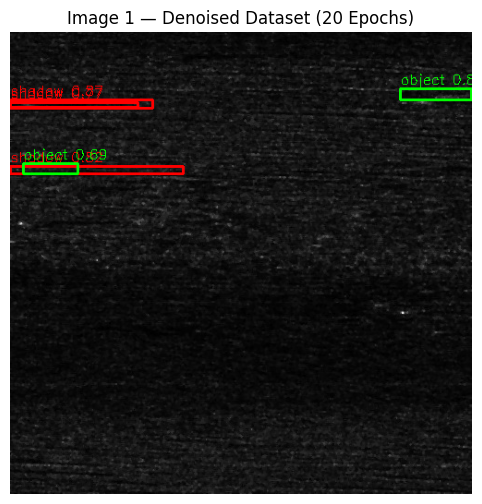

Image 2: 22 predictions above 0.50


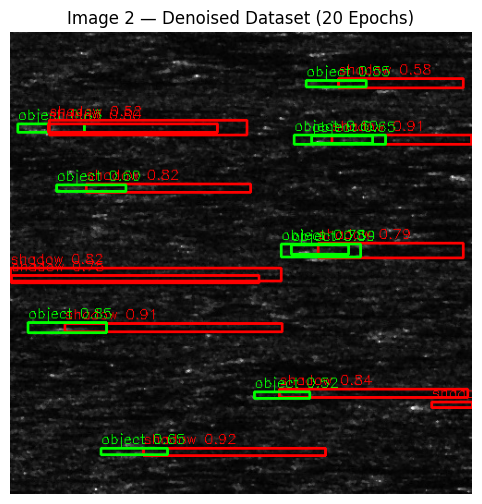

Image 3: 25 predictions above 0.50


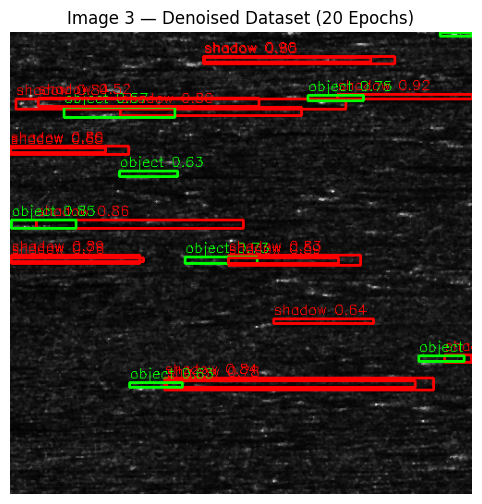

Image 4: 16 predictions above 0.50


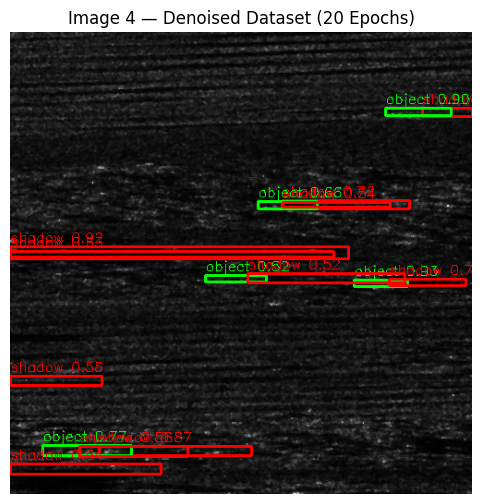

Image 5: 2 predictions above 0.50


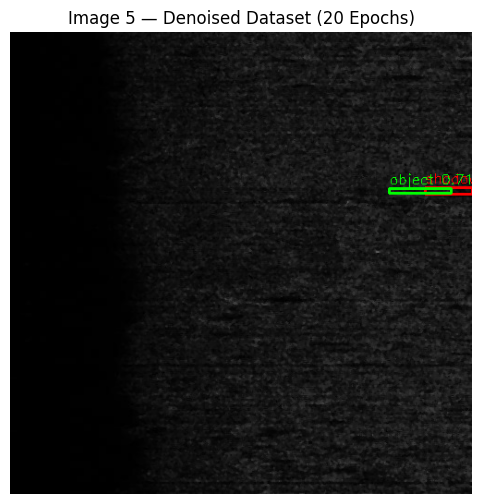

In [ ]:
# =============================================================
# VISUALIZE PREDICTIONS — FASTER R-CNN (20 EPOCHS, DENOISED DATA)
# =============================================================

import sys
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from PIL import Image
import cv2
import numpy as np
from pathlib import Path

# Add script path to import custom dataset
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset  # Uses object=1, shadow=2, background=0

# -------------------------------------------------------------
# CLASS MAPPINGS — Consistent with training + evaluation
# -------------------------------------------------------------

# Label IDs to names and visualization colors (OpenCV BGR)
LABEL_NAMES = {1: "object", 2: "shadow"}
LABEL_COLORS = {
    1: (0, 255, 0),   # object = green
    2: (0, 0, 255)    # shadow = red
}

# -------------------------------------------------------------
# VISUALIZATION FUNCTION FOR DENOISED SONAR DATASET
# -------------------------------------------------------------

def visualize_denoised(model, dataset_root, num_images=5, image_set="val", confidence_threshold=0.5):
    """
    Visualize Faster R-CNN predictions on denoised sonar data.
    """
    # Load Pascal VOC-style dataset
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())

    # Move model to eval mode and correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    for i in range(min(num_images, len(dataset))):
        img, _ = dataset[i]  # ground truth not used
        img_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)[0]

        # Convert image tensor to NumPy (for OpenCV drawing)
        img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR).copy()

        count = 0
        for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
            if score < confidence_threshold:
                continue

            x1, y1, x2, y2 = box.int().tolist()
            class_id = label.item()
            class_name = LABEL_NAMES.get(class_id, "unknown")
            color = LABEL_COLORS.get(class_id, (255, 255, 255))  # fallback = white

            cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_np, f"{class_name} {score:.2f}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            count += 1

        print(f"Image {i+1}: {count} predictions above {confidence_threshold:.2f}")

        # Show using matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Image {i+1} — Denoised Dataset (20 Epochs)")
        plt.show()

# -------------------------------------------------------------
# RUN VISUALIZATION
# -------------------------------------------------------------

visualize_denoised(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed",
    num_images=5,
    image_set="val",
    confidence_threshold=0.5
)

## **Train Faster RCNN Model on Augmentated Data**

In [ ]:
# =============================================================
# TRAIN FASTER R-CNN (20 EPOCHS) ON CLAHE & AUGMENTED SONAR DATA
# =============================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.v2 as T
from tqdm import tqdm

# -------------------------------------------------------------
# STEP 1: Dataset Paths and Split Check
# -------------------------------------------------------------
# This model is trained on sonar images that were preprocessed with:
# - CLAHE (Contrast Limited Adaptive Histogram Equalization)
# - Random augmentations (flip, rotate, brightness/contrast)
# These enhancements were applied in a separate preprocessing script.

DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented"
split_dir = Path(DATASET_DIR) / "ImageSets" / "Main"
image_dir = Path(DATASET_DIR) / "JPEGImages"

def check_split(txt_file, image_dir):
    with open(txt_file) as f:
        ids = [x.strip() for x in f.readlines()]
    return [i for i in ids if not (image_dir / f"{i}.jpg").exists()]

missing_train = check_split(split_dir / "train.txt", image_dir)
missing_val = check_split(split_dir / "val.txt", image_dir)

assert not missing_train, f"Missing train images: {missing_train}"
assert not missing_val, f"Missing val images: {missing_val}"
print("All training and validation images are accounted for.")

# -------------------------------------------------------------
# STEP 2: Custom VOCDataset Class
# -------------------------------------------------------------

class VOCDataset(Dataset):
    def __init__(self, root, image_set="train", transforms=None):
        self.root = root
        self.transforms = transforms
        self.image_dir = os.path.join(root, "JPEGImages")
        self.ann_dir = os.path.join(root, "Annotations")
        split_path = os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")
        with open(split_path) as f:
            self.image_ids = [x.strip() for x in f.readlines()]
        self.class_map = {"object": 1, "shadow": 2}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        ann_path = os.path.join(self.ann_dir, f"{img_id}.xml")

        img = Image.open(img_path).convert("RGB")
        target = self.parse_voc_xml(ann_path)

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes, labels = [], []

        for obj in root.findall("object"):
            label = self.class_map.get(obj.find("name").text.strip())
            if label is None:
                continue

            bbox = obj.find("bndbox")
            xmin = int(float(bbox.find("xmin").text))
            ymin = int(float(bbox.find("ymin").text))
            xmax = int(float(bbox.find("xmax").text))
            ymax = int(float(bbox.find("ymax").text))

            if xmax - xmin < 1 or ymax - ymin < 1:
                continue

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        if not boxes:
            boxes = [[0, 0, 1, 1]]
            labels = [0]

        return {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

# -------------------------------------------------------------
# STEP 3: Data Loaders and Transforms
# -------------------------------------------------------------

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transform = T.Compose([
    T.ToImage(),
    weights.transforms()  # Includes resizing, normalization (standard for COCO-pretrained models) with COCO = Common Object in Context
])

train_dataset = VOCDataset(DATASET_DIR, image_set="train", transforms=transform)
val_dataset   = VOCDataset(DATASET_DIR, image_set="val", transforms=weights.transforms())

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# -------------------------------------------------------------
# STEP 4: Build Faster R-CNN with Custom Head
# -------------------------------------------------------------

model = fasterrcnn_resnet50_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)
model.to(device)

# -------------------------------------------------------------
# STEP 5: Training Loop (20 Epochs, Cosine LR, Clip Gradients)
# -------------------------------------------------------------
# - Uses CosineAnnealingLR for gradual learning rate decay
# - Applies gradient clipping to stabilize training (avoids exploding gradients)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

for epoch in range(20):
    model.train()
    total_loss = 0.0

    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()

        # Clip gradients to prevent exploding gradients (stabilizes training)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        optimizer.step()
        total_loss += losses.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} — Avg Loss: {avg_loss:.4f}")

# -------------------------------------------------------------
# STEP 6: Save Model Checkpoint
# -------------------------------------------------------------

save_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_claheaug_20epoch.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All training and validation images are accounted for.
Using device: cuda
Training samples: 1429
Validation samples: 179


Epoch 1/20: 100%|██████████| 179/179 [33:06<00:00, 11.10s/it]


Epoch 1 — Avg Loss: 1.1907


Epoch 2/20: 100%|██████████| 179/179 [00:50<00:00,  3.52it/s]


Epoch 2 — Avg Loss: 1.1067


Epoch 3/20: 100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch 3 — Avg Loss: 1.0897


Epoch 4/20: 100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch 4 — Avg Loss: 1.0709


Epoch 5/20: 100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch 5 — Avg Loss: 1.0584


Epoch 6/20: 100%|██████████| 179/179 [00:51<00:00,  3.50it/s]


Epoch 6 — Avg Loss: 1.0534


Epoch 7/20: 100%|██████████| 179/179 [00:51<00:00,  3.51it/s]


Epoch 7 — Avg Loss: 1.0327


Epoch 8/20: 100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch 8 — Avg Loss: 1.0147


Epoch 9/20: 100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch 9 — Avg Loss: 0.9904


Epoch 10/20: 100%|██████████| 179/179 [00:51<00:00,  3.51it/s]


Epoch 10 — Avg Loss: 0.9675


Epoch 11/20: 100%|██████████| 179/179 [00:50<00:00,  3.52it/s]


Epoch 11 — Avg Loss: 0.9474


Epoch 12/20: 100%|██████████| 179/179 [00:50<00:00,  3.52it/s]


Epoch 12 — Avg Loss: 0.9253


Epoch 13/20: 100%|██████████| 179/179 [00:51<00:00,  3.51it/s]


Epoch 13 — Avg Loss: 0.9068


Epoch 14/20: 100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch 14 — Avg Loss: 0.8826


Epoch 15/20: 100%|██████████| 179/179 [00:51<00:00,  3.50it/s]


Epoch 15 — Avg Loss: 0.8657


Epoch 16/20: 100%|██████████| 179/179 [00:50<00:00,  3.52it/s]


Epoch 16 — Avg Loss: 0.8393


Epoch 17/20: 100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch 17 — Avg Loss: 0.8188


Epoch 18/20: 100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch 18 — Avg Loss: 0.7990


Epoch 19/20: 100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch 19 — Avg Loss: 0.7865


Epoch 20/20: 100%|██████████| 179/179 [00:50<00:00,  3.51it/s]


Epoch 20 — Avg Loss: 0.7791
Model saved to: /content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_claheaug_20epoch.pth


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Batch Inference (CLAHE + AUGMENTED VALIDATION)**

In [ ]:
# ========================================================================
# BATCH INFERENCE: FASTER R-CNN (20 EPOCHS, CLAHE + AUGMENTED VALIDATION SET)
# ========================================================================

import os
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# ------------------------------------------------------------------------
# STEP 1: PATHS AND DEVICE
# ------------------------------------------------------------------------

PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR = PROJECT_ROOT / "data" / "line2voc_preprocessed_augmented" / "JPEGImages"
MODEL_PATH = PROJECT_ROOT / "checkpoints" / "baseline_frcnn_claheaug_20epoch.pth"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "vis_claheaug_20epoch"
PRED_CSV = PROJECT_ROOT / "outputs" / "preds_claheaug_20epoch.csv"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------------------
# STEP 2: CUSTOM DATASET FOR INFERENCE
# ------------------------------------------------------------------------

class InferenceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted(list(Path(image_dir).glob("*.jpg")))
        self.transform = transform or ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_pil = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(img_pil)
        img_np = np.array(img_pil).astype(np.uint8)
        return img_tensor, img_path.name, img_np

# ------------------------------------------------------------------------
# STEP 3: LOAD MODEL AND CHECKPOINT
# ------------------------------------------------------------------------

model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# ------------------------------------------------------------------------
# STEP 4: BATCH INFERENCE AND VISUALIZATION
# ------------------------------------------------------------------------

CLASS_NAMES = {1: "object", 2: "shadow"}
CLASS_COLORS = {1: (0, 255, 0), 2: (0, 0, 255)}

dataset = InferenceDataset(IMG_DIR)
loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=lambda x: list(zip(*x)))

all_preds = []

print("Running inference on CLAHE & augmented sonar validation images...")

for batch_imgs, batch_filenames, batch_np_imgs in tqdm(loader, desc="Running Inference"):
    imgs_tensor = [img.to(device) for img in batch_imgs]

    with torch.no_grad():
        outputs = model(imgs_tensor)

    for output, fname, img_np in zip(outputs, batch_filenames, batch_np_imgs):
        img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        boxes  = output["boxes"].cpu()
        scores = output["scores"].cpu()
        labels = output["labels"].cpu()

        for box, score, label in zip(boxes, scores, labels):
            score = score.item()
            if score < 0.5:
                continue

            x1, y1, x2, y2 = map(int, box.tolist())
            class_id = label.item()
            class_name = CLASS_NAMES.get(class_id, "unknown")
            color = CLASS_COLORS.get(class_id, (255, 255, 255))

            all_preds.append({
                "filename": fname,
                "class_id": class_id,
                "class_name": class_name,
                "score": round(score, 4),
                "xmin": x1,
                "ymin": y1,
                "xmax": x2,
                "ymax": y2,
            })

            cv2.rectangle(img_cv2, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_cv2, f"{class_name} ({score:.2f})", (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        cv2.imwrite(str(OUTPUT_DIR / fname), img_cv2)

# ------------------------------------------------------------------------
# STEP 5: SAVE TO CSV
# ------------------------------------------------------------------------

df = pd.DataFrame(all_preds)
df.to_csv(PRED_CSV, index=False)

print("\nInference complete.")
print(f"Images processed: {len(dataset)}")
print(f"Visuals saved to: {OUTPUT_DIR}")
print(f"Predictions saved to: {PRED_CSV}")

Running inference on CLAHE & augmented sonar validation images...


Running Inference: 100%|██████████| 447/447 [01:14<00:00,  6.00it/s]



Inference complete.
Images processed: 1788
Visuals saved to: /content/drive/MyDrive/sonar-object-detection/outputs/vis_claheaug_20epoch
Predictions saved to: /content/drive/MyDrive/sonar-object-detection/outputs/preds_claheaug_20epoch.csv


## **EVALUATE FASTER R-CNN (20 EPOCHS) ON CLAHE + AUGMENTED SONAR DATA**


In [ ]:
# =============================================================
# EVALUATE FASTER R-CNN (20 EPOCHS) ON CLAHE & AUGMENTED SONAR DATA
# =============================================================

import sys
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Load VOCDataset loader
sys.path.append('/content/drive/MyDrive/sonar-object-detection/scripts')
from voc_dataset import VOCDataset

# -------------------------------------------------------------
# STEP 1: Set device and load model
# -------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT  # Match transforms with training

# Load model with custom head
model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load trained weights
model.load_state_dict(torch.load(
    "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_claheaug_20epoch.pth",
    map_location=device
))
model.to(device)
model.eval()

# -------------------------------------------------------------
# STEP 2: Evaluation function with TorchMetrics
# -------------------------------------------------------------

def evaluate(model, dataset_root, image_set="val", batch_size=4):
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=weights.transforms())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    metric = MeanAveragePrecision()
    label_map = {1: 'object', 2: 'shadow'}

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(imgs)

            preds, gts = [], []
            for o, t in zip(outputs, targets):
                if o["boxes"].nelement() == 0:
                    continue
                preds.append({
                    "boxes": o["boxes"].cpu(),
                    "scores": o["scores"].cpu(),
                    "labels": o["labels"].cpu()
                })
                gts.append({
                    "boxes": t["boxes"].cpu(),
                    "labels": t["labels"].cpu()
                })

            if preds and gts:
                metric.update(preds, gts)

    # -------------------------------------------------------------
    # STEP 3: Print evaluation results
    # -------------------------------------------------------------
    results = metric.compute()
    print("\nEvaluation Results — Faster R-CNN (20 Epochs, CLAHE & Augmented):")
    for k, v in results.items():
        if isinstance(v, torch.Tensor) and v.numel() == 1:
            print(f"{k}: {v.item():.4f}")
        else:
            print(f"{k}: {v}")

    print("\nPer-class mAP@0.50:")
    v = results.get("map_50_per_class")
    if isinstance(v, torch.Tensor) and v.numel() > 1:
        for idx, score in enumerate(v):
            class_id = idx + 1
            print(f"  {label_map.get(class_id, 'unknown')}: {score:.4f}")
    else:
        print("  Not available — model may have missed some classes.")

    print("\nPer-class Recall (mar_100_per_class):")
    v = results.get("mar_100_per_class")
    if isinstance(v, torch.Tensor) and v.numel() > 1:
        for idx, score in enumerate(v):
            class_id = idx + 1
            print(f"  {label_map.get(class_id, 'unknown')}: {score:.4f}")
    else:
        print("  Not available — likely due to low recall or missed class.")

# -------------------------------------------------------------
# STEP 4: Run on CLAHE & Augmented validation set
# -------------------------------------------------------------

evaluate(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented",
    image_set="val",
    batch_size=4
)


Evaluation Results — Faster R-CNN (20 Epochs, CLAHE & Augmented):
map: 0.0047
map_50: 0.0196
map_75: 0.0002
map_small: 0.0018
map_medium: 0.0088
map_large: 0.0000
mar_1: 0.0042
mar_10: 0.0195
mar_100: 0.0410
mar_small: 0.0233
mar_medium: 0.0725
mar_large: 0.0000
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: tensor([1, 2], dtype=torch.int32)

Per-class mAP@0.50:
  Not available — model may have missed some classes.

Per-class Recall (mar_100_per_class):
  Not available — likely due to low recall or missed class.


## **CLAHE and Augmented Model: Visualization**

Image 1: 14 predictions above 0.5


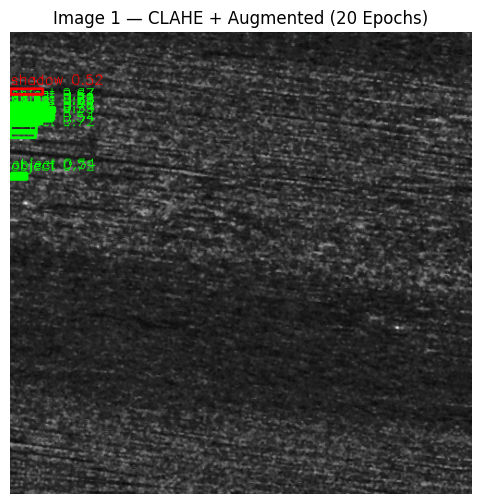

Image 2: 14 predictions above 0.5


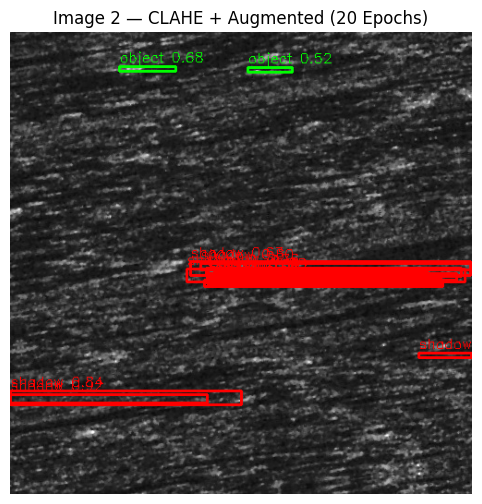

Image 3: 14 predictions above 0.5


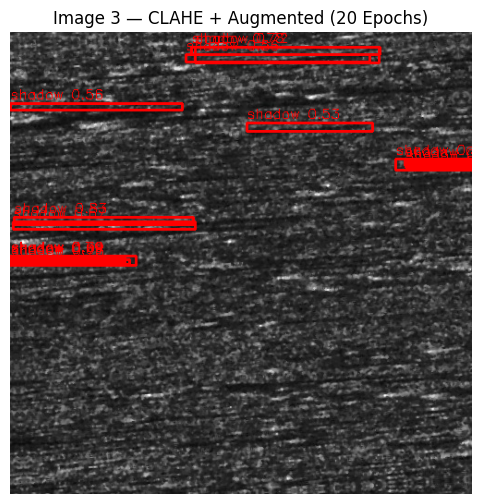

Image 4: 11 predictions above 0.5


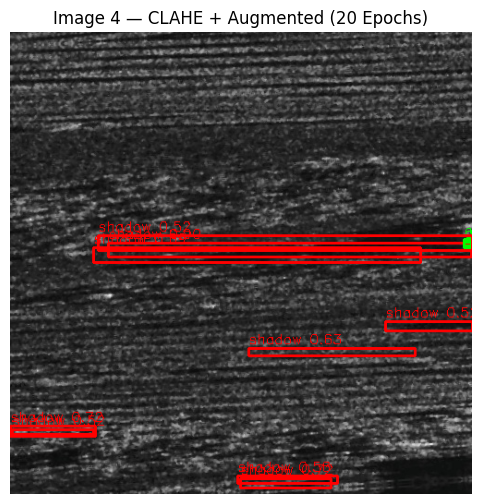

Image 5: 0 predictions above 0.5


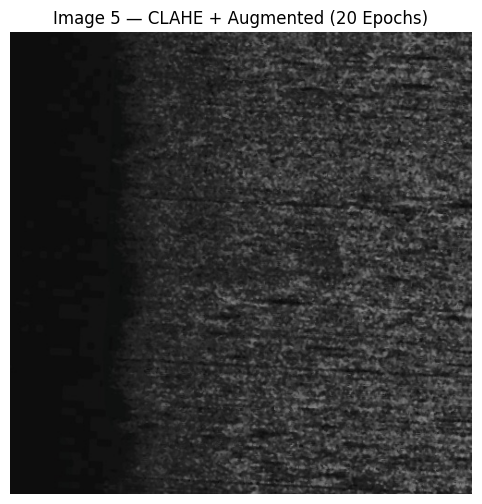

In [ ]:
# =============================================================
# VISUALIZE PREDICTIONS — FASTER R-CNN (20 EPOCHS, CLAHE + AUGMENTED DATA)
# =============================================================

import sys
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load custom VOCDataset loader
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

# -------------------------------------------------------------
# Label configuration — class names and OpenCV colors
# -------------------------------------------------------------

LABEL_NAMES = {
    1: "object",
    2: "shadow"
}

LABEL_COLORS = {
    1: (0, 255, 0),   # green for object
    2: (0, 0, 255)    # red for shadow
}

# -------------------------------------------------------------
# Visualization function for CLAHE + Augmented validation set
# -------------------------------------------------------------

def visualize_claheaug(model, dataset_root, num_images=5, image_set="val", confidence_threshold=0.5):
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    for i in range(min(num_images, len(dataset))):
        img, _ = dataset[i]
        img_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)[0]

        img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR).copy()

        count = 0
        for box, label, score in zip(output["boxes"], output["labels"], output["scores"]):
            if score < confidence_threshold:
                continue

            x1, y1, x2, y2 = box.int().tolist()
            class_id = label.item()
            class_name = LABEL_NAMES.get(class_id, "unknown")
            color = LABEL_COLORS.get(class_id, (255, 255, 255))  # fallback = white

            cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_np, f"{class_name} {score:.2f}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            count += 1

        print(f"Image {i+1}: {count} predictions above {confidence_threshold}")

        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Image {i+1} — CLAHE + Augmented (20 Epochs)")
        plt.show()

# -------------------------------------------------------------
# Run visualization
# -------------------------------------------------------------

visualize_claheaug(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented",
    num_images=5,
    image_set="val",
    confidence_threshold=0.5
)

## **Compare Detection Counts Across All 3 Faster R-CNN Models (raw, denoised, clahe+augmented) (20 Epochs)**

Loaded 34323 baseline predictions
Loaded 32145 denoised predictions
Loaded 39192 CLAHE and augmented predictions


Metric  Baseline (Raw)  Denoised  CLAHE + Augmented
0             Total Detections         34323.0  32145.00           39192.00
1    Mean Detections per Image            19.3     18.15              22.15
2  Median Detections per Image            19.0     18.00              22.00

/tmp/ipython-input-5-1323944613.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz_df, x="Model", y="Detections per Image", palette="pastel")


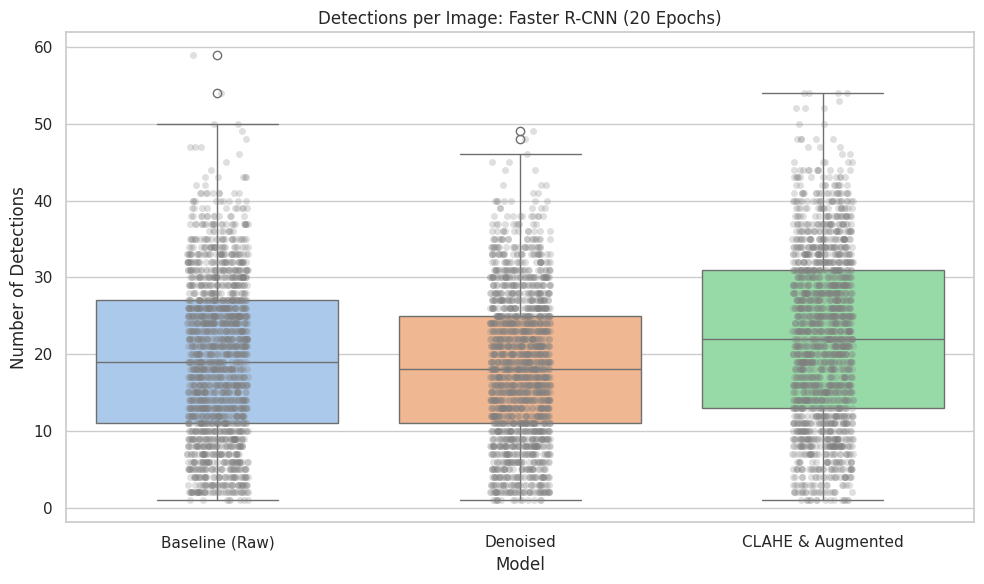

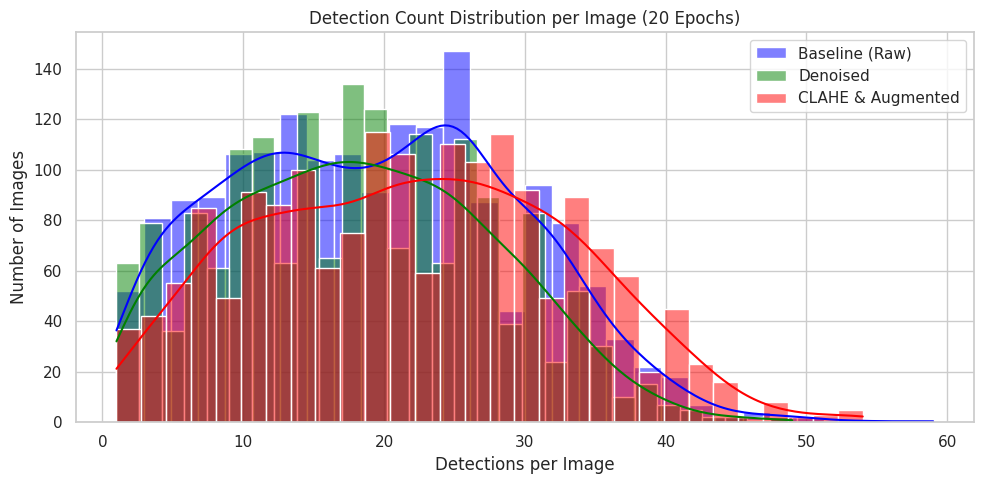

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# -----------------------------------------
# STEP 1: Define file paths to predictions
# -----------------------------------------

baseline_csv = "/content/drive/MyDrive/sonar-object-detection/outputs/preds_baseline_20epoch.csv"
denoised_csv = "/content/drive/MyDrive/sonar-object-detection/outputs/preds_denoised_20epoch.csv"
claheaug_csv = "/content/drive/MyDrive/sonar-object-detection/outputs/preds_claheaug_20epoch.csv"

# -----------------------------------------
# STEP 2: Load all prediction CSVs
# -----------------------------------------

baseline_preds = pd.read_csv(baseline_csv)
denoised_preds = pd.read_csv(denoised_csv)
claheaug_preds = pd.read_csv(claheaug_csv)

print(f"Loaded {len(baseline_preds)} baseline predictions")
print(f"Loaded {len(denoised_preds)} denoised predictions")
print(f"Loaded {len(claheaug_preds)} CLAHE and augmented predictions")

# -----------------------------------------
# STEP 3: Count detections per image
# -----------------------------------------

baseline_counts = baseline_preds.groupby("filename").size()
denoised_counts = denoised_preds.groupby("filename").size()
claheaug_counts = claheaug_preds.groupby("filename").size()

# -----------------------------------------
# STEP 4: Summary table
# -----------------------------------------

summary_df = pd.DataFrame({
    "Metric": ["Total Detections", "Mean Detections per Image", "Median Detections per Image"],
    "Baseline (Raw)": [
        len(baseline_preds),
        round(baseline_counts.mean(), 2),
        baseline_counts.median()
    ],
    "Denoised": [
        len(denoised_preds),
        round(denoised_counts.mean(), 2),
        denoised_counts.median()
    ],
    "CLAHE + Augmented": [
        len(claheaug_preds),
        round(claheaug_counts.mean(), 2),
        claheaug_counts.median()
    ]
})

display(summary_df)

# -----------------------------------------
# STEP 5: Prepare data for Seaborn
# -----------------------------------------

viz_df = pd.DataFrame({
    "Model": (
        ["Baseline (Raw)"] * len(baseline_counts) +
        ["Denoised"] * len(denoised_counts) +
        ["CLAHE & Augmented"] * len(claheaug_counts)
    ),
    "Detections per Image": pd.concat([baseline_counts, denoised_counts, claheaug_counts])
})

# -----------------------------------------
# STEP 6: Boxplot + Stripplot
# -----------------------------------------

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(data=viz_df, x="Model", y="Detections per Image", palette="pastel")
sns.stripplot(data=viz_df, x="Model", y="Detections per Image", color="gray", alpha=0.25, jitter=True)
plt.title("Detections per Image: Faster R-CNN (20 Epochs)")
plt.ylabel("Number of Detections")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

# -----------------------------------------
# STEP 7: Histogram
# -----------------------------------------

plt.figure(figsize=(10, 5))
sns.histplot(baseline_counts, label="Baseline (Raw)", color="blue", bins=30, kde=True, stat="count", alpha=0.5)
sns.histplot(denoised_counts, label="Denoised", color="green", bins=30, kde=True, stat="count", alpha=0.5)
sns.histplot(claheaug_counts, label="CLAHE & Augmented", color="red", bins=30, kde=True, stat="count", alpha=0.5)

plt.legend()
plt.title("Detection Count Distribution per Image (20 Epochs)")
plt.xlabel("Detections per Image")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.grid(True)
plt.show()